In [ ]:
# Install VELO SDK for easy API access
%pip install velo-sdk matplotlib polars python-dotenv --quiet

In [107]:
%config InlineBackend.figure_format = 'svg'

In [ ]:
import os

import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from velo_sdk.api import APIClient

In [ ]:
try:
    from google.colab import auth, userdata

    auth.authenticate_user()
    os.environ["RISKTHINKING_API_KEY"] = userdata.get("RISKTHINKING_API_KEY")
except:
    # Not in Colab or error retrieving secret; skip Colab-specific logic
    pass

In [ ]:
client = APIClient()

In [ ]:
company = client.companies.search_companies(name="Apple Inc", limit=1)[0]
company_id = company.id

In [246]:
data = client.companies.list_company_assets(company_id=company_id)
assets = pl.DataFrame(data)

In [247]:
# Create Equal-Width Bins
all_scores = assets["materiality_score"].to_numpy()
edges = np.linspace(0, 100, 11)

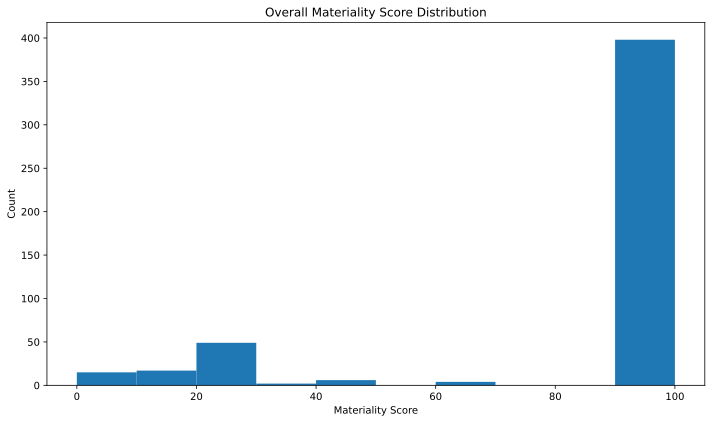

In [248]:
plt.figure(figsize=(10, 6))
plt.hist(all_scores, bins=edges)
plt.title("Overall Materiality Score Distribution")
plt.xlabel("Materiality Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

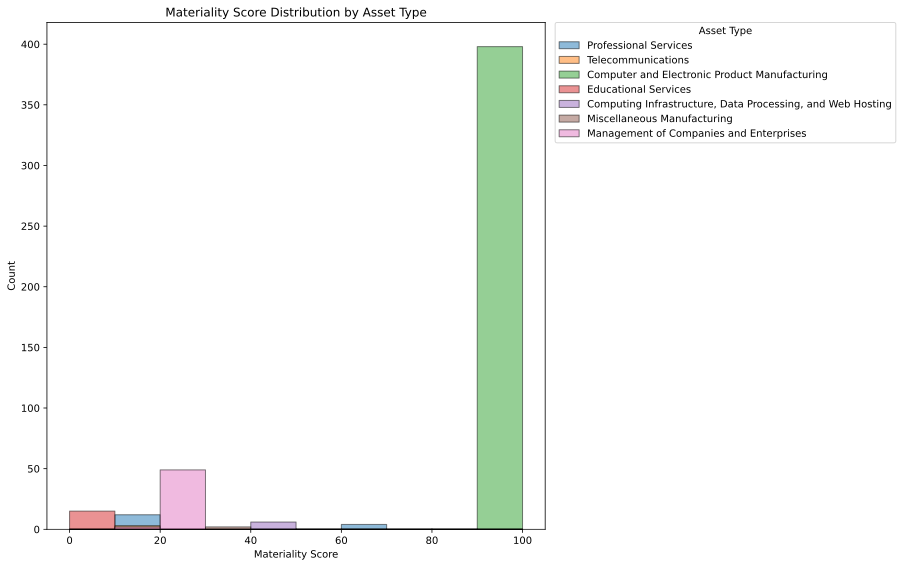

In [249]:
fig, ax = plt.subplots(figsize=(15, 8))

for atype in assets["asset_type"].unique().to_list():
    subset = (
        assets.filter(pl.col("asset_type") == atype)
        .select("materiality_score")
        .to_numpy()
    )
    ax.hist(subset, bins=edges, alpha=0.5, label=atype, edgecolor="black")

ax.set_title("Materiality Score Distribution by Asset Type")
ax.set_xlabel("Materiality Score")
ax.set_ylabel("Count")

ax.legend(
    title="Asset Type", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Average Asset Risk By Materiality

In [250]:
horizon = 2025
pathway = "RT3"
score_df = pl.DataFrame()
metric = "cvar_95"


data = client.companies.list_company_asset_climate_scores(
    company_id=company.id, horizon=horizon, pathway=pathway, metric=metric
)

score_df = pl.DataFrame(data).with_columns(
    [pl.lit(horizon).alias("horizon"), pl.lit(pathway).alias("pathway")]
)

In [251]:
materiality_w_risk = assets[["id", "asset_type", "materiality_score"]].join(
    score_df[["asset_id", "cvar_95"]], left_on="id", right_on="asset_id"
)

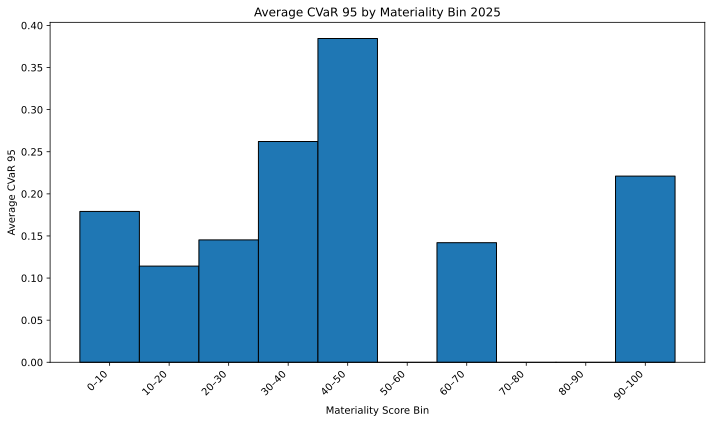

In [252]:
all_scores = materiality_w_risk["materiality_score"].to_numpy()
all_cvar = materiality_w_risk["cvar_95"].to_numpy()
edges = np.linspace(0, 100, 11)

counts, _ = np.histogram(all_scores, bins=edges)
sum_cvar, _ = np.histogram(all_scores, bins=edges, weights=all_cvar)

avg_cvar = np.divide(sum_cvar, counts, out=np.zeros_like(sum_cvar), where=counts > 0)

bin_centers = (edges[:-1] + edges[1:]) / 2

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, avg_cvar, width=np.diff(edges), edgecolor="black", align="center")
plt.xlabel("Materiality Score Bin")
plt.ylabel("Average CVaR 95")
plt.title("Average CVaR 95 by Materiality Bin 2025")
plt.xticks(
    bin_centers,
    [f"{int(edges[i])}–{int(edges[i+1])}" for i in range(len(edges) - 1)],
    rotation=45,
    ha="right",
)
plt.tight_layout()
plt.show()

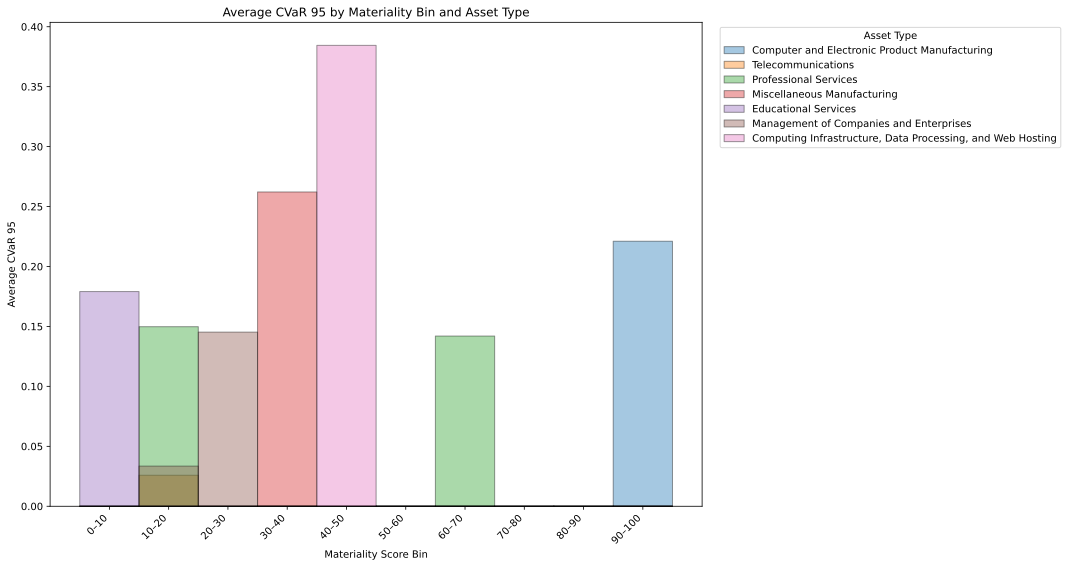

In [253]:
plt.figure(figsize=(15, 8))
width = edges[1] - edges[0]

for atype in materiality_w_risk["asset_type"].unique().to_list():
    sub = materiality_w_risk.filter(pl.col("asset_type") == atype)
    scores = sub["materiality_score"].to_numpy()
    cvars = sub["cvar_95"].to_numpy()

    counts, _ = np.histogram(scores, bins=edges)
    sum_cvar, _ = np.histogram(scores, bins=edges, weights=cvars)
    avg_cvar = np.divide(
        sum_cvar, counts, out=np.zeros_like(sum_cvar, dtype=float), where=counts > 0
    )

    plt.bar(
        bin_centers, avg_cvar, width=width, alpha=0.4, label=atype, edgecolor="black"
    )

plt.xticks(
    bin_centers,
    [f"{int(edges[i])}–{int(edges[i+1])}" for i in range(len(edges) - 1)],
    rotation=45,
    ha="right",
)
plt.xlabel("Materiality Score Bin")
plt.ylabel("Average CVaR 95")
plt.title("Average CVaR 95 by Materiality Bin and Asset Type")
plt.legend(title="Asset Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()